In [1]:
import os
import sys
from glob import glob
import numpy as np
import pandas as pd

import nibabel as nib
from nilearn import datasets, surface, plotting, image
from nilearn.surface import vol_to_surf
from nilearn.image import resample_to_img
from nilearn.input_data import NiftiMasker
from nilearn.plotting import (
    plot_surf_roi,
    view_surf,
    plot_stat_map,
    plot_surf_contours
)

from statsmodels.stats.multitest import multipletests

sys.path.append('../general_functions/')
from plotting_brains_surfplot import (
    map_values_to_atlas,
    calc_alpha,
    make_translucent_map,
    Plot,
    check_surf
)

fsaverage = datasets.fetch_surf_fsaverage()


/Users/f004p59/.local/lib/python3.7/site-packages/nilearn/__init__.py:67: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()
/Users/f004p59/.local/lib/python3.7/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
from surfplot.surf import plot_surf
#from surfplot import Plot -- importing modified Class
from brainspace.datasets import load_parcellation
from brainspace.mesh.mesh_io import read_surface
from neuromaps.datasets import fetch_fslr

surfaces = fetch_fslr()
lh, rh = surfaces['inflated']
atlas_surf = load_parcellation('schaefer', 100, join = True)

#DEFINING THE COLOR MAPS
from matplotlib.colors import LinearSegmentedColormap


basic_cols=['k', 'k', 'k']
black_cmap=LinearSegmentedColormap.from_list('mycmap', basic_cols)

basic_cols=['blue', 'blue', 'blue']
blue_cmap=LinearSegmentedColormap.from_list('mycmap', basic_cols)

homemade_diverging_yellow =LinearSegmentedColormap.from_list('homemade_diverging', (
    # Edit this gradient at https://eltos.github.io/gradient/#homemade_diverging=0:5394FF-50:FFFFFF-74.9:E8DD62-89.3:B9AB0E-100:8C8637
    (0.000, (0.325, 0.580, 1.000)),
    (0.500, (1.000, 1.000, 1.000)),
    (0.749, (0.910, 0.867, 0.384)),
    (0.893, (0.725, 0.671, 0.055)),
    (1.000, (0.549, 0.525, 0.216))))

In [3]:
all_sub = pd.read_csv('model_outputs/lmer_across_node_estimate_reevaluated_episode_by_GLM_episodelabel_as_random_effect_include_subcortical.csv')


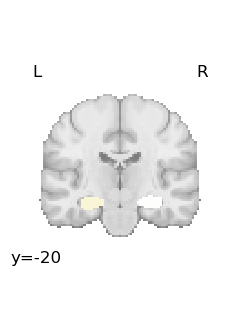

In [5]:

atlas_name = 'sub-maxprob-thr0-2mm'
harvard_oxford = datasets.fetch_atlas_harvard_oxford(atlas_name)

atlas = harvard_oxford.maps

hippocampus_indices = [9, 19]
hippocampus_indices = [9, 19]  


hippocampus_mask_L = (atlas.get_fdata() == hippocampus_indices[0]).astype(int)
hippocampus_mask_R = (atlas.get_fdata() == hippocampus_indices[1]).astype(int)

# Combine masks into one
combined_mask = np.zeros(atlas.shape)
combined_mask[hippocampus_mask_L == 1] = list(all_sub[all_sub['node']=='hippocampus_data_L']['estimate'])[0]
combined_mask[hippocampus_mask_R == 1] = list(all_sub[all_sub['node']=='hippocampus_data_R']['estimate'])[0]

combined_img = nib.Nifti1Image(combined_mask, atlas.affine)

display = plotting.plot_stat_map(combined_img, display_mode='y', cut_coords=[-20], colorbar=False, cmap=homemade_diverging_yellow,vmax=.1)
display.savefig('../../plots/Fig2._episodes/reappraisal_fig_hippocampus.png', dpi=300)

plotting.show()

In [6]:

bad_ROIs = [30, 31, 32, 78, 79]
threshold = 0.05

vals = np.array(list(all_sub['estimate']))
p_vals = np.array(list(all_sub['p']))

#filter out the bad ROIs
for idx, a in enumerate(vals):
    if idx in bad_ROIs:
        vals[idx] = np.nan

# Identify significant indices for p-values at the threshold
significant_p_indices = np.where(p_vals < threshold)[0]
# Exclude any bad ROIs from the significant indices
significant_p_indices = [idx for idx in significant_p_indices if idx not in bad_ROIs]

# Perform FDR correction for q-values
q_vals = multipletests(p_vals, method='fdr_bh')[1]
significant_q_indices = np.where(q_vals < threshold)[0]
# Exclude any bad ROIs from the significant q-value indices
significant_q_indices = [idx for idx in significant_q_indices if idx not in bad_ROIs]

p_regions = [idx for idx in significant_p_indices]  
q_regions = [idx for idx in significant_q_indices]  


print(f"Indices of significant values at p < {threshold}: {p_regions}")
print(f"Indices of significant values at q < {threshold}: {q_regions}")

p_regions = [val for val in p_regions if val not in (100, 101)] #want to plot just cortex
q_regions = [val for val in q_regions if val not in (100, 101)]


Indices of significant values at p < 0.05: [13, 26, 37, 38, 39, 40, 46, 91, 92]
Indices of significant values at q < 0.05: [37, 38, 39, 40]


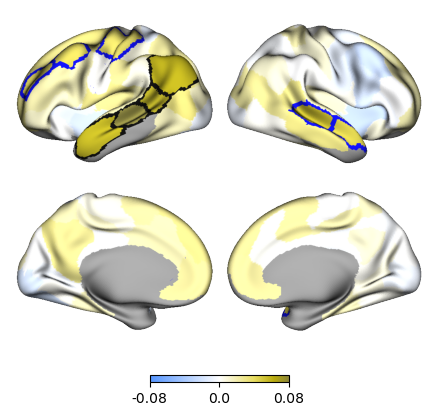

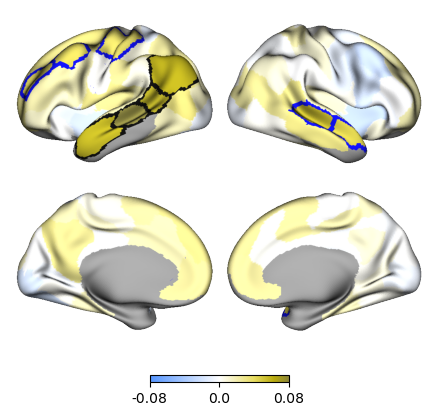

In [42]:
new_array = map_values_to_atlas(atlas_surf, np.array(vals))

translucent_map = make_translucent_map(new_array, np.nanmax(np.abs(new_array))*.20, new_array)
translucent_map 

p = Plot(lh, rh, views=['lateral', 'medial'])

p.add_layer(translucent_map , cbar=True, cmap=homemade_diverging_yellow, color_range=(-.08, .08), zero_transparent=False)

for region in p_regions:
    p_plot = [0] * 100
    p_plot[region] = 1  # Mark the current region
    p_array = map_values_to_atlas(atlas_surf, p_plot)
    
    # Add this region as a separate layer
    p.add_layer(p_array, cmap=blue_cmap, as_outline=True, cbar=False, outline_thickness=2)

# # Apply the mapping function for each region in q_plot (q < .01)
for region in q_regions:
    q_plot = [0] * 100
    q_plot[region] = 1  # Mark the current region
    q_array = map_values_to_atlas(atlas_surf, q_plot)
    
    # Add this region as a separate layer
    p.add_layer(q_array, cmap=black_cmap, as_outline=True, cbar=False, outline_thickness=2)


a = p.build()
fig = p.build()  
fig.savefig('../../plots/02._reappraisal_segments/02._reappraisal_cortical_fig.png', dpi=300)
fig.savefig('../../plots/02._reappraisal_segments/02._reappraisal_cortical_fig.svg', dpi=300)

